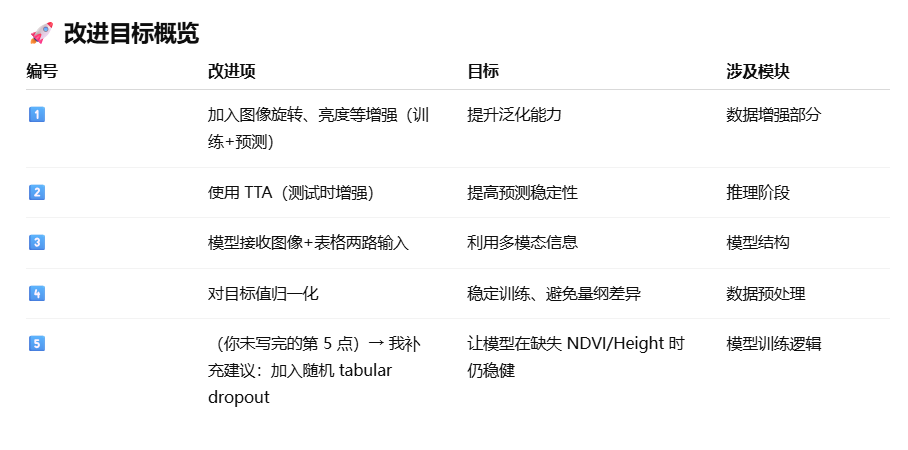

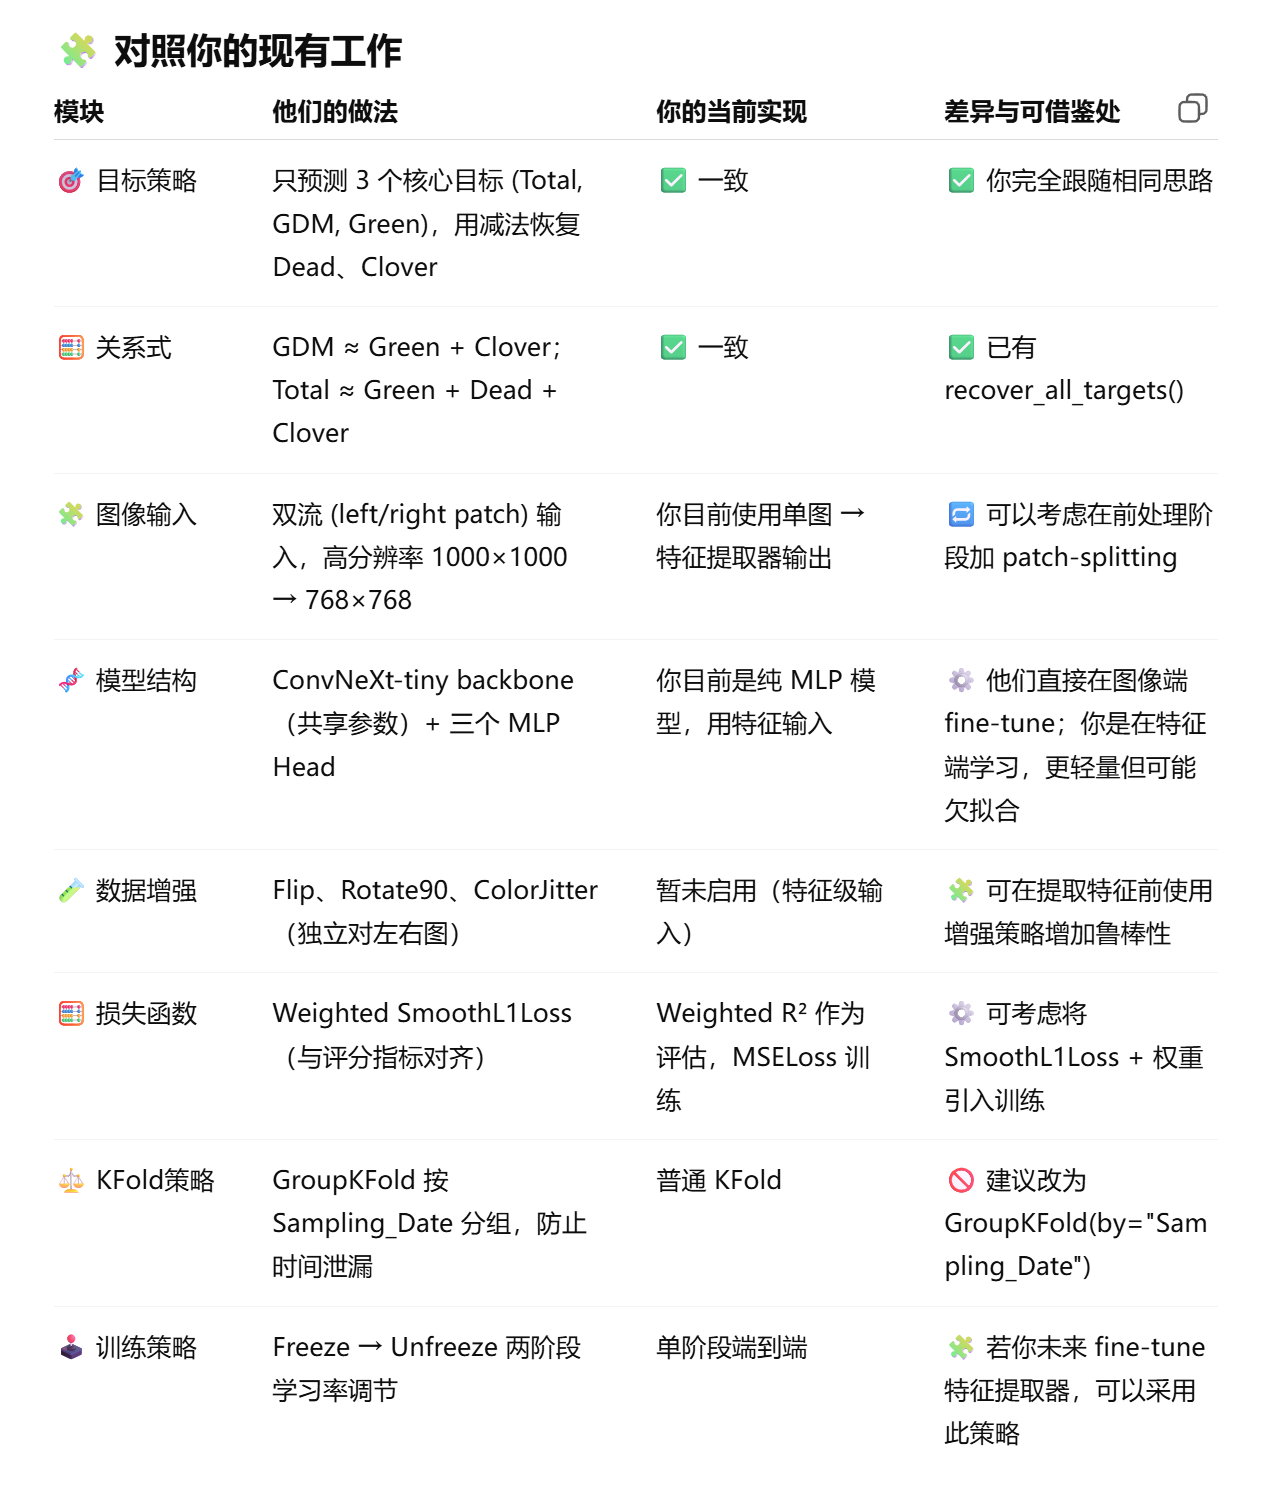

In [ ]:
# 📁 main_inference.py
# │
# ├── 1️⃣ CONFIGURATION (CFG)
# │     ├── 数据路径、模型路径、设备设置
# │     ├── 模型名称 convnext_tiny + 图像大小 768 × 768
# │     ├── 目标列 TARGET_COLS (3 个预测) 与 ALL_TARGET_COLS (5 个提交)
# │
# ├── 2️⃣ AUGMENTATIONS + TTA 定义
# │     ├── get_tta_transforms(): 返回三种视图  
# │     │     • 原图  
# │     │     • 水平翻转  
# │     │     • 垂直翻转  
# │     └── 基于 albumentations + ToTensorV2 实现
# │
# ├── 3️⃣ Dataset 定义 (TestBiomassDataset)
# │     ├── 输入 2000×1000 原图 → 拆为左右 1000×1000 patch  
# │     ├── 各 patch 都应用同一个 TTA 变换  
# │     └── 返回 (img_left_tensor, img_right_tensor)
# │
# ├── 4️⃣ 模型结构 (BiomassModel)
# │     ├── backbone : timm .create_model("convnext_tiny", num_classes=0)
# │     ├── 两路特征 → 拼接 (torch.cat) → 多头输出
# │     │     • head_total → Dry_Total_g  
# │     │     • head_gdm → GDM_g  
# │     │     • head_green → Dry_Green_g  
# │     └── forward(): 返回 (total, gdm, green)
# │
# ├── 5️⃣ 单视图预测函数 (predict_one_view)
# │     ├── 输入: 已加载的 5 fold 模型 + 一个 TTA view 的 DataLoader  
# │     ├── 对每个 batch 执行 5 fold ensemble 取均值  
# │     └── 输出: 3 个目标的 numpy 数组 (total, gdm, green)
# │
# ├── 6️⃣ 主推理函数 (run_inference_with_tta)
# │     ├── 加载 test.csv 与 test 图像路径  
# │     ├── 加载 5 个 fold 的权重文件 (best_model_foldX.pth)  
# │     ├── 逐 TTA 视图循环  
# │     │     • 创建 Dataset 和 DataLoader  
# │     │     • 调用 predict_one_view  
# │     ├── 汇总 TTA 视图 平均预测  
# │     └── 返回 final_preds + df_long + df_unique
# │
# ├── 7️⃣ 创建 Submission (create_submission)
# │     ├── 计算 Clover = max(0, GDM − Green)  
# │     ├── 计算 Dead = max(0, Total − GDM)  
# │     ├── 组装 5 列 Dry_Green_g … Dry_Total_g  
# │     ├── melt 回 long 格式并 merge sample_id  
# │     └── 输出 submission.csv
# │
# └── 8️⃣ Main 入口
#       ├── 运行 run_inference_with_tta()
#       └── 调用 create_submission()


In [ ]:
import os
import socket
from pathlib import Path
from PIL import Image

import pandas as pd
import torch
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.models as models
import h5py
# =========================================
# 📦 导入依赖
# =========================================
import os
import torch
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score
from torch import nn
from torch.utils.data import Dataset, DataLoader


# =========================================
# ⚙️ 0️⃣ 全局参数配置
# =========================================
import torch
from torchvision import models
from torchvision.models import get_model_weights
from pathlib import Path
import os
import random
import numpy as np
import torch
import os
from tqdm import tqdm
import numpy as np
# 固定随机种子
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

# 禁用 cuDNN 的非确定性算法
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
os.environ["PYTHONHASHSEED"] = str(seed)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"✅ 使用设备: {device}")

In [ ]:
# 初始化
if socket.gethostname() == 'hao-2':
    dir = Path('D:/DATA_hao/Kaggle_/csiro-biomass/')
    DIRS = {
    "dir":        dir,                                       
    "train":     Path(dir, "train"),                              
    "test":     Path(dir, "test"),                              
    "model":     Path(dir,"feature_extractor_models"),              
    "data":     Path(dir),   
    }
else:
    dir = Path('/kaggle/input/csiro-biomass')
    DIRS = {
    "dir":        dir,                                       
    "train":     Path(dir, "train"),                              
    "test":     Path(dir, "test"),                              
    "model":     Path('/kaggle/input', "feature-extractor-models"),              
    "data":     Path("/kaggle/working/"),   
    }




# # 自动创建目录
# for key, path in DIRS.items():
#     os.makedirs(path, exist_ok=True)

# 打印时一行一个地址
print("✅ 路径已创建：\n")
for key, path in DIRS.items():
    print(f"{key:<12} : {path}")






In [ ]:
# 小函数
def show_df_info(df, name: str, max_cols=100):
    """
    打印单个 DataFrame 的形状与列名信息。
    如果列数超过 max_cols，自动折叠连续特征列（如 img_feat_1...img_feat_256）。
    """
    cols = df.columns.tolist()
    n_cols = len(cols)
    msg = f"📊 {name:<16} shape: {str(df.shape):<16} "

    if n_cols <= max_cols:
        # ✅ 正常打印
        msg += f"列名: {cols}"
    else:
        # ✅ 统计 img_feat_* 栏目
        feat_cols = [c for c in cols if c.startswith("img_feat_")]
        other_cols = [c for c in cols if not c.startswith("img_feat_")]

        msg += f"列名: {other_cols[:10]} ..."

        if feat_cols:
            msg += f" + [img_feat_* 共 {len(feat_cols)} 列]"
        if len(other_cols) > 10:
            msg += f"（其余 {len(other_cols)-10} 列省略）"

    print(msg)

def move_column_first(df, col_name):
    """
    将 DataFrame 中指定列移动到最前面。
    参数:
        df (pd.DataFrame): 原始数据框
        col_name (str): 要移动到最前面的列名
    返回:
        pd.DataFrame: 调整后的新 DataFrame
    """
    if col_name not in df.columns:
        raise ValueError(f"列 '{col_name}' 不存在于 DataFrame 中。")

    cols = [col_name] + [c for c in df.columns if c != col_name]
    return df[cols]


from sklearn.metrics import r2_score

def weighted_r2(y_true_df, y_pred_df):
    weights = {
        "Dry_Green_g": 0.1,
        "Dry_Dead_g": 0.1,
        "Dry_Clover_g": 0.1,
        "GDM_g": 0.2,
        "Dry_Total_g": 0.5
    }

    r2_dict = {}
    for col in weights.keys():
        r2_dict[col] = r2_score(y_true_df[col], y_pred_df[col])

    weighted_score = sum(r2_dict[k] * w for k, w in weights.items())
    return weighted_score, r2_dict



### 🧩 1. 数据准备

从 **CSV 文件**   &nbsp;    →  &nbsp;  **`df`**   &nbsp;   唯一标识符 **`ID`** 

**🧱 数据结构说明：**

* 🏷️ **标志位字段：**
  `ID`, `sample_id`, `image_path`, `my_file_path`

* 🌿 **可用特征字段：**
  `Sampling_Date`, `State`, `Species`, `Pre_GSHH_NDVI`, `Height_Ave_cm`

* 🎯 **预测目标字段：**
  `Dry_Clover_g`, `Dry_Dead_g`, `Dry_Green_g`, `Dry_Total_g`, `GDM_g`

#### 训练数据csv处理

In [ ]:
# 📘 数据读取与预处理

# 1️⃣ 读取原始数据
df_file_path = Path(DIRS["dir"] / "train.csv")
df = pd.read_csv(df_file_path)
show_df_info(df, "train.csv")



# 2️⃣ 提取唯一 ID（例如 "ID1011485656__Dry_Green_g" → "ID1011485656"）
df["ID"] = df["sample_id"].str.split("__").str[0]

# 3️⃣ 将 ID 列移动到最前面
df = move_column_first(df, "ID")
show_df_info(df, "df")

# 🧩 目标值透视（行转列）
df_targets = (
    df
    .pivot_table(
        index="ID",
        columns="target_name",
        values="target",
        aggfunc="first"
    )
    .reset_index()
)
df_targets.columns.name = None  # 去掉多级列名层次
show_df_info(df_targets, "df_targets")

# 🧬 提取元信息（每个 ID 仅保留一行）
meta_cols = [
    "ID", "image_path", "Sampling_Date", "State",
    "Species", "Pre_GSHH_NDVI", "Height_Ave_cm"
]
df_meta = df[meta_cols].drop_duplicates(subset="ID")
show_df_info(df_meta, "df_meta")

# 🔗 合并元信息与目标数据
df_wide = pd.merge(df_meta, df_targets, on="ID", how="left")

# 🖼️ 生成完整图像路径列
df_wide["my_file_path"] = df_wide["image_path"].apply(
    lambda x: Path(DIRS["train"], Path(x).name)
)
show_df_info(df_wide, "df_wide")

# 🧾 示例输出
print("📷 示例文件路径:", df_wide.loc[0, "my_file_path"])

# df_wide.head()


#### 训练数据pic处理

In [ ]:
# 图片转特征向量  底层处理代码
# ======================================
# 1️⃣ 从本地加载模型
# ======================================
def load_saved_model(name, base_dir, device):
    path = base_dir / f"{name}_feature_extractor.pth"
    if not path.exists():
        raise FileNotFoundError(f"❌ 未找到模型文件: {path}")
    model = torch.load(path, map_location=device, weights_only=False)
    model.eval().to(device)
    print(f"✅ 已加载模型: {name}")
    return model

resnet50   = load_saved_model("resnet50", DIRS["model"], device)
effnetb3   = load_saved_model("efficientnet_b3", DIRS["model"], device)
convnext_t = load_saved_model("convnext_tiny", DIRS["model"], device)

# | 模型              | 输出维度 | 若拆成两块后拼接 | 
# | ----------------- | ---- | -------- | 
# | `resnet50`        | 2048 | **4096** |
# | `efficientnet_b3` | 1536 | **3072** | 
# | `convnext_tiny`   | 768  | **1536** | 



# ======================================
# 2️⃣ 图像预处理（官方推荐）
# ======================================
# 这些参数与你当初下载权重时默认 transforms 一致
resnet_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])
effnet_transform = transforms.Compose([
    transforms.Resize(300),
    transforms.CenterCrop(300),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])
convnext_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# ======================================
# 3️⃣ 单张图像的特征提取函数
# ======================================
def extract_feature(image_path, model, transform, split=False):
    try:
        image = Image.open(image_path).convert("RGB")
    except Exception as e:
        print(f"⚠️ 无法读取图片: {image_path} ({e})")
        return None

    if split:
        w, h = image.size
        # 仅在宽度明显大于高度时拆分
        if w >= 2 * h:
            patches = [image.crop((0, 0, w//2, h)),
                       image.crop((w//2, 0, w, h))]
        else:
            patches = [image]
    else:
        patches = [image]

    features = []
    for patch in patches:
        x = transform(patch).unsqueeze(0).to(device)
        with torch.no_grad():
            f = model(x).squeeze().cpu().numpy()
        features.append(f)

    # 这里可以选择不同的融合策略
    if len(features) == 1:
        return features[0]
    else:
        # 策略1：取平均（推荐）
        # return np.mean(features, axis=0)

        # 策略2：拼接（如果模型输入特征较短）
        return np.concatenate(features)




# ======================================
# 4️⃣ 批量特征提取
# ======================================
def extract_all_features(df, path_col, models_dict, transforms_dict):
    all_features, ids = [], []

    for i, row in tqdm(df.iterrows(), total=len(df), desc="Extracting multi-model features"):
        img_path = row[path_col]
        if not os.path.exists(img_path):
            print(f"⚠️ 图片不存在: {img_path}")
            continue

        feats = []
        for name in models_dict.keys():
            model = models_dict[name]
            transform = transforms_dict[name]
            f = extract_feature(img_path, model, transform, split = True)
            if f is not None:
                feats.append(f)

        # 拼接多个模型特征
        if len(feats) > 0:
            all_features.append(np.concatenate(feats))
            ids.append(row["ID"])

    # 保存 npy 文件
    all_features = np.vstack(all_features)
    print(f"\n✅ 特征处理完成 shape = {all_features.shape}")
    return all_features, ids


# ======================================
# 5️⃣ 模型 & 变换配置
# ======================================
models_dict = {
    "resnet50": resnet50,
    "effnetb3": effnetb3,
    "convnext_t": convnext_t
}
transforms_dict = {
    "resnet50": resnet_transform,
    "effnetb3": effnet_transform,
    "convnext_t": convnext_transform
}


In [ ]:
# # 6️⃣ 运行特征提取
features, ids = extract_all_features(
    df=df_wide,
    path_col="my_file_path",
    models_dict=models_dict,
    transforms_dict=transforms_dict
)

# 将特征矩阵转为 DataFrame
df_img_feats = pd.DataFrame(features, columns=[f"img_feat_{i + 1}" for i in range(features.shape[1])])

# 添加 ID 列
df_img_feats["ID"] = ids

# 调整列顺序，让 ID 放在最前
df_img_feats = move_column_first(df_img_feats, "ID")

# 保存为 Feather 文件（高效的二进制格式）
df_img_feats.to_feather(Path(DIRS["data"] / "train_img_feats.feather"))

show_df_info(df_img_feats, "图像特征")
print("✅ 多模型特征提取完成并已保存！")





In [ ]:
# csv 和 pic 数据合并

import pandas as pd
df_img_feats = pd.read_feather(Path(DIRS["data"]) / "train_img_feats.feather")
df_train = df_wide.merge(df_img_feats, on="ID", how="left")

print(f"✅ 合并完成: {df_train.shape}")
show_df_info(df_train, "df_train")


#### 测试数据csv处理

In [ ]:
# 📘 数据读取与预处理

# 1️⃣ 读取原始数据
df_file_path = Path(DIRS["dir"] / "test.csv")
df = pd.read_csv(df_file_path)
show_df_info(df, "test.csv")



# 2️⃣ 提取唯一 ID（例如 "ID1011485656__Dry_Green_g" → "ID1011485656"）
df["ID"] = df["sample_id"].str.split("__").str[0]

# 3️⃣ 将 ID 列移动到最前面
df = move_column_first(df, "ID")


df["target"] = 0

show_df_info(df, "df")

# 🧩 目标值透视（行转列）
df_targets = (
    df
    .pivot_table(
        index="ID",
        columns="target_name",
        values="target",
        aggfunc="first"
    )
    .reset_index()
)
df_targets.columns.name = None  # 去掉多级列名层次
show_df_info(df_targets, "df_targets")

# 🧬 提取元信息（每个 ID 仅保留一行）
# meta_cols = [
#     "ID", "image_path", "Sampling_Date", "State",
#     "Species", "Pre_GSHH_NDVI", "Height_Ave_cm"
# ]

meta_cols = [
    "ID", "image_path"
]
df_meta = df[meta_cols].drop_duplicates(subset="ID")
show_df_info(df_meta, "df_meta")

# 🔗 合并元信息与目标数据
df_wide = pd.merge(df_meta, df_targets, on="ID", how="left")

# 🖼️ 生成完整图像路径列
df_wide["my_file_path"] = df_wide["image_path"].apply(
    lambda x: Path(DIRS["test"], Path(x).name)
)
show_df_info(df_wide, "df_wide")

# 🧾 示例输出
print("📷 示例文件路径:", df_wide.loc[0, "my_file_path"])

# df_wide.head()


#### 测试数据pic处理

In [ ]:
# 6️⃣ 运行特征提取
features, ids = extract_all_features(
    df=df_wide,
    path_col="my_file_path",
    models_dict=models_dict,
    transforms_dict=transforms_dict
)

# 将特征矩阵转为 DataFrame
df_img_feats = pd.DataFrame(features, columns=[f"img_feat_{i + 1}" for i in range(features.shape[1])])

# 添加 ID 列
df_img_feats["ID"] = ids

# 调整列顺序，让 ID 放在最前
df_img_feats = move_column_first(df_img_feats, "ID")

# 保存为 Feather 文件（高效的二进制格式）
df_img_feats.to_feather(Path(DIRS["data"] / "test_img_feats.feather"))

show_df_info(df_img_feats, "图像特征")
print("✅ 多模型特征提取完成并已保存！")





In [ ]:
# csv 和 pic 数据合并

import pandas as pd
df_img_feats = pd.read_feather(Path(DIRS["data"]) / "test_img_feats.feather")
df_test = df_wide.merge(df_img_feats, on="ID", how="left")

print(f"✅ 合并完成: {df_test.shape}")
show_df_info(df_test, "df_test")


# 模型

#### 加载训练数据

In [ ]:
# 全部列
all_cols = [
    'ID', 'image_path', 'my_file_path', 'Sampling_Date', 'State', 'Species',
    'Pre_GSHH_NDVI', 'Height_Ave_cm',
    'Dry_Green_g', 'Dry_Dead_g', 'Dry_Clover_g', 'GDM_g', 'Dry_Total_g'
] + [f"img_feat_{i}" for i in range(8689, 8691)]  # 示例范围

# 目标列
model_target_cols = ["Dry_Green_g", "GDM_g", "Dry_Total_g"]
target_cols = ['Dry_Green_g', 'Dry_Dead_g', 'Dry_Clover_g', 'GDM_g', 'Dry_Total_g']

# 特征列（自动提取）
feature_cols = [c for c in df_train.columns if 'img_feat_' in c]


X_train = df_train[feature_cols].astype(np.float32)
y_train = df_train[model_target_cols].astype(np.float32)

print(f"✅ 特征维度: {X_train.shape}, 目标维度: {y_train.shape}")

#### 加载预测数据

In [ ]:

feature_cols = [c for c in df_train.columns if 'img_feat_' in c]

X_test = df_test[feature_cols].astype(np.float32)

print(f"✅ 特征维度: {X_test.shape}")

#### 数据标准化

In [ ]:
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np

# 1️⃣ 初始化 scaler
scaler = StandardScaler()

# 2️⃣ 用训练集拟合，再应用到训练 & 测试集
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

# 3️⃣ 转回 DataFrame，保留列名（方便后续特征对齐）
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test_scaled  = pd.DataFrame(X_test_scaled,  columns=X_test.columns,  index=X_test.index)

# 4️⃣ 检查
print(f"✅ 标准化完成：train mean={X_train_scaled.mean().mean():.4f}, std={X_train_scaled.std().mean():.4f}")


#### 训练

In [ ]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
from pathlib import Path


# =======================
# 🎯 目标权重
# =======================
weights = {
    "Dry_Green_g": 0.1,
    "GDM_g": 0.2,
    "Dry_Total_g": 0.5,
}

# =======================
# 🧮 Weighted R² 函数
# =======================
def weighted_r2(y_true, y_pred, weights):
    r2_dict = {}
    for i, col in enumerate(weights.keys()):
        r2_dict[col] = r2_score(y_true[:, i], y_pred[:, i])
    weighted_score = sum(r2_dict[k] * w for k, w in weights.items())
    return weighted_score, r2_dict


class WeightedSmoothL1Loss(nn.Module):
    def __init__(self, weights):
        super().__init__()
        self.weights = weights
        self.loss_fn = nn.SmoothL1Loss(reduction='none')

    def forward(self, pred, target):
        loss = self.loss_fn(pred, target)
        weighted = sum(loss[:, i] * w for i, w in enumerate(self.weights.values()))
        return weighted.mean()


# =======================
# 📦 Dataset 定义
# =======================
class PastureDataset(Dataset):
    def __init__(self, X, y=None):
        self.X = torch.tensor(X.values, dtype=torch.float32)
        self.y = None if y is None else torch.tensor(y.values, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        if self.y is None:
            return self.X[idx]
        return self.X[idx], self.y[idx]


# =======================
# 🧠 MLP 模型定义
# =======================
class MLPRegressor(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, output_dim)
        )

    def forward(self, x):
        return self.net(x)


# =======================
# 🔁 训练 + 可视化函数
# =======================
def train_with_kfold(X, y, target_cols, k=5):
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    oof_preds = np.zeros_like(y)
    fold_scores = []

    for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
        print(f"\n🧩 Fold {fold+1}/{k}")

        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        print(f"Train: {X_train.shape}, Val: {X_val.shape}")

        train_ds = PastureDataset(X_train, y_train)
        val_ds = PastureDataset(X_val, y_val)
        train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False)

        model = MLPRegressor(input_dim=X.shape[1], output_dim=len(target_cols)).to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        # criterion = nn.MSELoss()
        criterion = WeightedSmoothL1Loss(weights)


        best_val_loss = np.inf
        patience_counter = 0
        history = {"train_loss": [], "val_loss": []}

        for epoch in range(epochs):
            # ---------- Train ----------
            model.train()
            train_losses = []
            for xb, yb in train_loader:
                xb, yb = xb.to(device), yb.to(device)
                optimizer.zero_grad()
                preds = model(xb)
                loss = criterion(preds, yb)
                loss.backward()
                optimizer.step()
                train_losses.append(loss.item())

            # ---------- Validate ----------
            model.eval()
            val_losses = []
            preds_list, true_list = [], []
            with torch.no_grad():
                for xb, yb in val_loader:
                    xb, yb = xb.to(device), yb.to(device)
                    preds = model(xb)
                    val_losses.append(criterion(preds, yb).item())
                    preds_list.append(preds.cpu().numpy())
                    true_list.append(yb.cpu().numpy())

            val_loss = np.mean(val_losses)
            history["train_loss"].append(np.mean(train_losses))
            history["val_loss"].append(val_loss)

            print(f"Epoch {epoch+1:03d} | val_loss: {val_loss:.5f}", end="\r")

            # ---------- Early stopping ----------
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                patience_counter = 0
                torch.save(model.state_dict(), save_dir / f"fold{fold+1}_best.pt")
            else:
                patience_counter += 1
                if patience_counter >= early_stop_patience:
                    print(f"⏸️ 早停于第 {epoch+1} 轮 (最佳 val_loss={best_val_loss:.5f})")
                    break

        # ---------- 可视化 ----------
        plt.figure(figsize=(6, 2))
        plt.plot(history["train_loss"], label="Train Loss")
        plt.plot(history["val_loss"], label="Val Loss")
        plt.title(f"Fold {fold+1} Loss Curve")
        plt.xlabel("Epoch")
        plt.ylabel("MSE Loss")
        plt.legend()
        plt.grid(alpha=0.3)
        plt.tight_layout()
        plt.show()

        # ---------- 验证集预测 ----------
        model.load_state_dict(torch.load(save_dir / f"fold{fold+1}_best.pt"))
        model.eval()
        with torch.no_grad():
            val_preds = model(torch.tensor(X_val.values, dtype=torch.float32).to(device)).cpu().numpy()

        oof_preds[val_idx] = val_preds
        weighted_score, detail = weighted_r2(y_val.values, val_preds, weights)
        fold_scores.append(weighted_score)

        print(f"🎯 Fold {fold+1} Weighted R²: {weighted_score:.4f}")
        for k_, v_ in detail.items():
            print(f"   {k_}: {v_:.4f}")

    # ---------- 综合评估 ----------
    df_scores = pd.DataFrame({"fold": np.arange(1, k + 1), "score": fold_scores})
    df_scores.to_csv("fold_scores.csv", index=False)
    print("✅ 已保存每折得分 fold_scores.csv")

    overall_score, overall_detail = weighted_r2(y.values, oof_preds, weights)
    print("\n📊 最终结果")
    print(f"平均 Fold Weighted R²: {np.mean(fold_scores):.4f}")
    print(f"整体 OOF Weighted R²: {overall_score:.4f}")
    for k_, v_ in overall_detail.items():
        print(f"  {k_}: {v_:.4f}")

    df_pred = pd.DataFrame(oof_preds, columns=target_cols)
    df_pred["ID"] = df_train["ID"]
    df_pred.to_csv("nn_oof_predictions.csv", index=False)
    print("✅ 已保存预测结果: nn_oof_predictions.csv")



🧩 Fold 1/10
Train: (321, 8704), Val: (36, 8704)
⏸️ 早停于第 71 轮 (最佳 val_loss=6.33999)


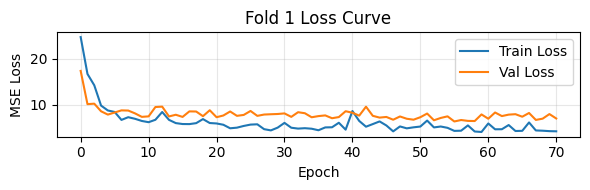

🎯 Fold 1 Weighted R²: 0.5373
   Dry_Green_g: 0.7065
   GDM_g: 0.7104
   Dry_Total_g: 0.6492

🧩 Fold 2/10
Train: (321, 8704), Val: (36, 8704)
⏸️ 早停于第 41 轮 (最佳 val_loss=6.96224)


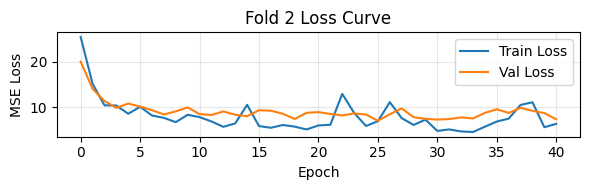

🎯 Fold 2 Weighted R²: 0.5701
   Dry_Green_g: 0.7524
   GDM_g: 0.7736
   Dry_Total_g: 0.6803

🧩 Fold 3/10
Train: (321, 8704), Val: (36, 8704)
⏸️ 早停于第 74 轮 (最佳 val_loss=9.37438)


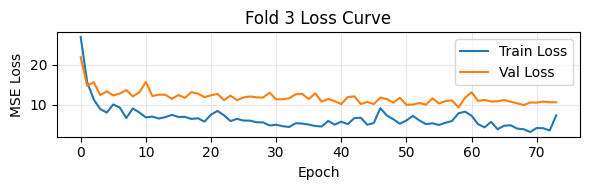

🎯 Fold 3 Weighted R²: 0.4158
   Dry_Green_g: 0.6403
   GDM_g: 0.5942
   Dry_Total_g: 0.4659

🧩 Fold 4/10
Train: (321, 8704), Val: (36, 8704)
⏸️ 早停于第 29 轮 (最佳 val_loss=7.70958)


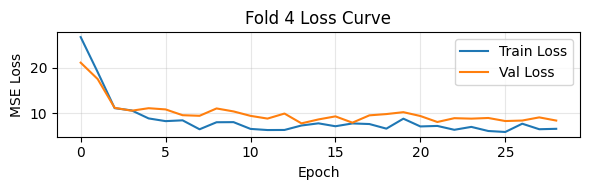

🎯 Fold 4 Weighted R²: 0.5759
   Dry_Green_g: 0.6727
   GDM_g: 0.7193
   Dry_Total_g: 0.7295

🧩 Fold 5/10
Train: (321, 8704), Val: (36, 8704)
⏸️ 早停于第 36 轮 (最佳 val_loss=7.33011)


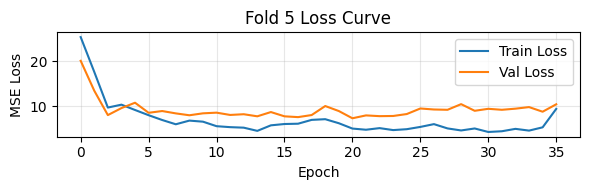

🎯 Fold 5 Weighted R²: 0.5707
   Dry_Green_g: 0.7763
   GDM_g: 0.8098
   Dry_Total_g: 0.6622

🧩 Fold 6/10
Train: (321, 8704), Val: (36, 8704)
⏸️ 早停于第 40 轮 (最佳 val_loss=7.58530)


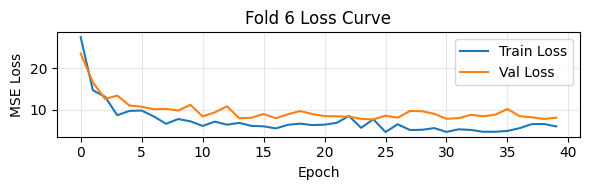

🎯 Fold 6 Weighted R²: 0.6298
   Dry_Green_g: 0.8000
   GDM_g: 0.7769
   Dry_Total_g: 0.7889

🧩 Fold 7/10
Train: (321, 8704), Val: (36, 8704)
⏸️ 早停于第 37 轮 (最佳 val_loss=7.46782)


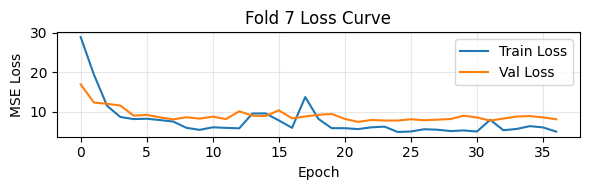

🎯 Fold 7 Weighted R²: 0.5164
   Dry_Green_g: 0.5401
   GDM_g: 0.6895
   Dry_Total_g: 0.6489

🧩 Fold 8/10
Train: (322, 8704), Val: (35, 8704)
⏸️ 早停于第 53 轮 (最佳 val_loss=9.77121)


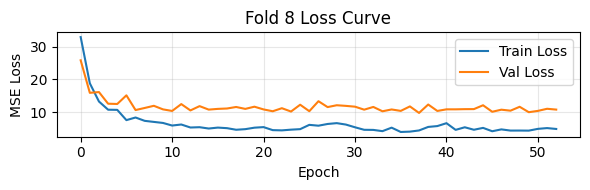

🎯 Fold 8 Weighted R²: 0.5502
   Dry_Green_g: 0.7375
   GDM_g: 0.7262
   Dry_Total_g: 0.6624

🧩 Fold 9/10
Train: (322, 8704), Val: (35, 8704)
⏸️ 早停于第 35 轮 (最佳 val_loss=7.67772)


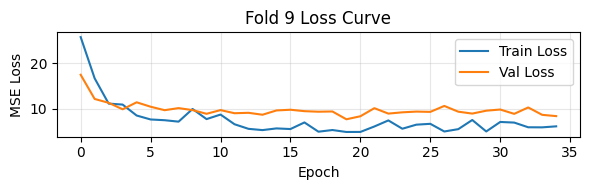

🎯 Fold 9 Weighted R²: 0.4256
   Dry_Green_g: 0.5348
   GDM_g: 0.5553
   Dry_Total_g: 0.5220

🧩 Fold 10/10
Train: (322, 8704), Val: (35, 8704)
⏸️ 早停于第 98 轮 (最佳 val_loss=6.48686)


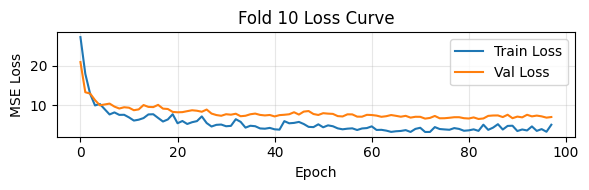

🎯 Fold 10 Weighted R²: 0.5314
   Dry_Green_g: 0.7135
   GDM_g: 0.6895
   Dry_Total_g: 0.6443
✅ 已保存每折得分 fold_scores.csv

📊 最终结果
平均 Fold Weighted R²: 0.5323
整体 OOF Weighted R²: 0.5458
  Dry_Green_g: 0.7035
  GDM_g: 0.7139
  Dry_Total_g: 0.6654
✅ 已保存预测结果: nn_oof_predictions.csv


In [19]:
n_splits = 10      # 可自定义 KFold 折数


batch_size = 64
lr = 1e-3
epochs = 200
early_stop_patience = 15
save_dir = Path(DIRS["model"], "test_version")
save_dir.mkdir(exist_ok=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


train_with_kfold(X_train_scaled, y_train, model_target_cols, k=n_splits)

In [20]:
# 根据模型预测的3个目标 推导出完整的5个目标
def recover_all_targets(df_pred_3):

    df = df_pred_3.copy()

    # 防止列名顺序错乱
    required_cols = ["Dry_Green_g", "GDM_g", "Dry_Total_g"]
    for col in required_cols:
        if col not in df.columns:
            raise ValueError(f"缺少列: {col}，请确保模型预测输出正确。")

    # 计算衍生变量
    df["Dry_Clover_g"] = np.maximum(0, df["GDM_g"] - df["Dry_Green_g"])
    df["Dry_Dead_g"] = np.maximum(0, df["Dry_Total_g"] - df["GDM_g"])

    # 重新排列列顺序
    df = df[[
        "Dry_Green_g", "Dry_Dead_g", "Dry_Clover_g",
        "GDM_g", "Dry_Total_g"
    ]]
    return df


In [21]:
# 使用验证集最优的 top_k 个折模型进行推理并平均预测

def predict_with_top_folds(
    X_test,
    target_cols,
    model_class,
    save_dir,
    fold_score_file=None,
    top_k=5,
    n_splits=10,
    batch_size=32,
    device=None
):
    """
    🧪 使用验证集最优的 top_k 个折模型进行推理并平均预测。

    参数:
        X_test (pd.DataFrame): 测试集特征
        target_cols (list[str]): 目标列名称
        model_class (nn.Module): 模型类，如 MLPRegressor
        save_dir (str | Path): 模型保存路径
        fold_score_file (str | Path): 每折得分文件 (CSV)，需包含 'fold' 和 'score' 列
        top_k (int): 使用得分最高的前 K 个模型
        n_splits (int): 总折数
        batch_size (int): 推理批量大小
        device (torch.device): 设备 (默认自动选择 CUDA)
    返回:
        np.ndarray: 平均预测结果 (shape=[n_samples, n_targets])
    """
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    save_dir = Path(save_dir)

    print("\n=================== 🧪 开始测试集推理 (Top Folds) ===================")

    # 1️⃣ 读取或构造折叠得分
    if fold_score_file and Path(fold_score_file).exists():
        df_score = pd.read_csv(fold_score_file)
        df_score = df_score.sort_values("score", ascending=False)
        top_folds = df_score["fold"].head(top_k).tolist()
        for _, row in df_score.iterrows():
            print(f"   • 折 {int(row['fold']):3d}: 分数 = {row['score']:.4f}")

        print(f"📊 从文件中读取得分，选择前 {top_k} 个最优折: {top_folds}")
    else:
        # 若无得分文件，则默认使用 1~top_k 折
        top_folds = list(range(1, top_k + 1))
        print(f"⚠️ 未提供得分文件，默认选择折 {top_folds}")

    # 2️⃣ DataLoader
    test_ds = PastureDataset(X_test)
    test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=0)

    test_preds_all = []

    # 3️⃣ 推理 top_k 模型
    for fold in top_folds:
        model_path = save_dir / f"fold{fold}_best.pt"
        if not model_path.exists():
            print(f"⚠️ 未找到模型文件: {model_path}")
            continue

        print(f"🔹 使用模型: {model_path.name}")
        model = model_class(input_dim=X_test.shape[1], output_dim=len(target_cols)).to(device)
        model.load_state_dict(torch.load(model_path, map_location=device))
        model.eval()

        fold_preds = []
        with torch.inference_mode():
            for xb in test_loader:
                xb = xb.to(device)
                preds = model(xb)
                fold_preds.append(preds.cpu().numpy())

        fold_preds = np.vstack(fold_preds)
        test_preds_all.append(fold_preds)

    if not test_preds_all:
        raise RuntimeError("❌ 没有找到任何有效模型文件，请检查路径或 fold 选择。")

    # 4️⃣ 多折平均
    test_preds_mean = np.mean(test_preds_all, axis=0)
    print(f"✅ 推理完成，平均 {len(test_preds_all)} 个模型结果，shape: {test_preds_mean.shape}")

    return test_preds_mean


In [22]:
# 使用最优折模型预测测试集
test_preds_mean = predict_with_top_folds(
    X_test=X_test_scaled,
    target_cols=model_target_cols,      # 即 ["Dry_Green_g", "GDM_g", "Dry_Total_g"]
    model_class=MLPRegressor,
    save_dir=save_dir,
    fold_score_file="fold_scores.csv",  # 训练阶段保存的各折得分文件
    top_k=10,                           # ✅ 选择最优前10折进行加权平均
    n_splits=n_splits,
    batch_size=batch_size,
)

# 将预测结果转为 DataFrame
df_pred3 = pd.DataFrame(test_preds_mean, columns=model_target_cols)
show_df_info(df_pred3, "df_pred3 ")

# 恢复完整的 5 个目标列
df_pred5 = recover_all_targets(df_pred3)
show_df_info(df_pred5, "df_pred5 ")

# 追加样本 ID 并调整列顺序
df_pred5["ID"] = df_test["ID"]
df_pred5 = df_pred5[["ID"] + target_cols]

# 打印结果预览
show_df_info(df_pred5, "final df_pred5")





=================== 🧪 开始测试集推理 (Top Folds) ===================
   • 折   6: 分数 = 0.6298
   • 折   4: 分数 = 0.5759
   • 折   5: 分数 = 0.5707
   • 折   2: 分数 = 0.5701
   • 折   8: 分数 = 0.5502
   • 折   1: 分数 = 0.5373
   • 折  10: 分数 = 0.5314
   • 折   7: 分数 = 0.5164
   • 折   9: 分数 = 0.4256
   • 折   3: 分数 = 0.4158
📊 从文件中读取得分，选择前 10 个最优折: [6, 4, 5, 2, 8, 1, 10, 7, 9, 3]
🔹 使用模型: fold6_best.pt
🔹 使用模型: fold4_best.pt
🔹 使用模型: fold5_best.pt
🔹 使用模型: fold2_best.pt
🔹 使用模型: fold8_best.pt
🔹 使用模型: fold1_best.pt
🔹 使用模型: fold10_best.pt
🔹 使用模型: fold7_best.pt
🔹 使用模型: fold9_best.pt
🔹 使用模型: fold3_best.pt
✅ 推理完成，平均 10 个模型结果，shape: (1, 3)
📊 df_pred3         shape: (1, 3)           列名: ['Dry_Green_g', 'GDM_g', 'Dry_Total_g']
📊 df_pred5         shape: (1, 5)           列名: ['Dry_Green_g', 'Dry_Dead_g', 'Dry_Clover_g', 'GDM_g', 'Dry_Total_g']
📊 final df_pred5   shape: (1, 6)           列名: ['ID', 'Dry_Green_g', 'Dry_Dead_g', 'Dry_Clover_g', 'GDM_g', 'Dry_Total_g']


In [23]:
# =========================================
# 📤 5️⃣ 生成 Kaggle 提交文件 submission.csv
# =========================================
# 按指定顺序展开
ordered_target_cols = [
    "Dry_Clover_g",  # 1️⃣
    "Dry_Dead_g",    # 2️⃣
    "Dry_Green_g",   # 3️⃣
    "Dry_Total_g",   # 4️⃣
    "GDM_g"          # 5️⃣
]

df_submit = (
    df_pred5
    .melt(id_vars="ID", value_vars=ordered_target_cols,
          var_name="target_name", value_name="target")
)

# 组合成 Kaggle 所需的 sample_id
df_submit["sample_id"] = df_submit["ID"] + "__" + df_submit["target_name"]

df_submit = move_column_first(df_submit, "target")
df_submit = move_column_first(df_submit, "sample_id")

# 只保留 Kaggle 要的两列
df_submit = df_submit[["sample_id", "target"]]
df_submit
# 按 sample_id 排序（可选）
# df_submit = df_submit.sort_values("sample_id").reset_index(drop=True)

# 保存文件
df_submit.to_csv("submission.csv", index=False)
print("✅ 已生成提交文件 submission.csv")


✅ 已生成提交文件 submission.csv
